In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixture, GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.06.07


In [99]:
from scipy.stats import spearmanr
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import copy

# Load data

In [4]:
known_marker_genes=["SOX2","SLC17A7","EOMES"]
novel_marker_genes=["CLU","FBXO32","UNC5D","SEZ6","RBFOX1"]
their_genes=["DCX","GRIA3","STMN2", "FAM64A","ELAVL4","RNASEH2B"]
marker_genes = known_marker_genes + novel_marker_genes + their_genes

In [5]:
adata = sc.read('data/hgForebrainGlut.loom')
gene_names = adata.var_names
adata.var_names

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Index(['FAM138A', 'RP11-34P13.7', 'RP11-34P13.8', 'AL627309.1',
       'RP11-34P13.14', 'AP006222.2', 'RP4-669L17.2', 'RP5-857K21.1',
       'RP5-857K21.3', 'RP5-857K21.4',
       ...
       'BPY2', 'DAZ2', 'AC016752.1', 'TTTY17B', 'TTTY4B', 'BPY2B', 'DAZ4',
       'CSPG4P1Y', 'CDY1', 'TTTY3'],
      dtype='object', name='Gene', length=32738)

In [6]:
gene_length_file = np.loadtxt("data/gg_200525_genome_polyA_cum_3.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0].upper() for gene in gene_length_file])
print(np.sum(adata.var_names.isin(gene_name)))

20350


In [7]:
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
print(Clusters)
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
cell_colors = colors20[np.mod(clusters, 20)]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", colors20[:7], N=7)

{0, 1, 2, 3, 4, 5, 6}


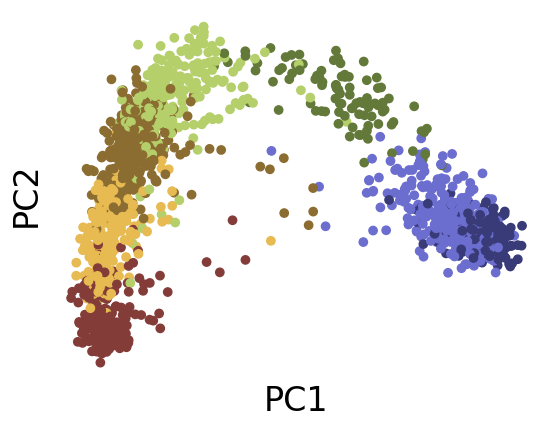

In [8]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X.toarray()/total_UMI[:,None]*np.mean(total_UMI)))

fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [9]:
# Read the Excel file
file_path = 'data/Schofield_ST2.xlsx'
Schofield = pd.read_excel(file_path,sheet_name='Table S2_K562')

# Calculate decay rate
Schofield['Decay Rate'] = np.log(2) / Schofield['mean_half_life']
Schofield = Schofield[~Schofield['Decay Rate'].isna()]

Schofield.head()

gene_name = adata.var_names.tolist()
Schofield_gamma = []
data_genes = np.array(Schofield['transcript'].tolist())
data_rates = np.array(Schofield['Decay Rate'].tolist())
nan = 0 

for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Schofield_gamma.append(data_rates[idx])
    else:
        Schofield_gamma.append(np.nan)
        nan += 1
        
Schofield_gamma = np.array(Schofield_gamma)
nan 

27542

In [102]:
# Dyrec-seq, Hela cell
file_path = 'data/Dyrec-seq_ST.xlsx'
df = pd.read_excel(file_path,sheet_name='Table S4',header=2)
#df.head()

# Extract gene name and decay rate columns
Dyrec_data = df.iloc[:,[1,3]].copy()
Dyrec_data.columns = ['Name', 'Decay Rate']

# Print the extracted data
Dyrec_data.head()

Dyrec_gamma = []
data_genes = np.array([gene.upper() for gene in Dyrec_data['Name'].astype(str).tolist()])
data_rates = np.array(Dyrec_data['Decay Rate'].tolist())

gene_name = adata.var_names.tolist()
nan = 0 
for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Dyrec_gamma.append(data_rates[idx])
    else:
        Dyrec_gamma.append(np.nan)
        nan += 1
        
Dyrec_gamma = np.array(Dyrec_gamma)
nan 

28319

# Select genes

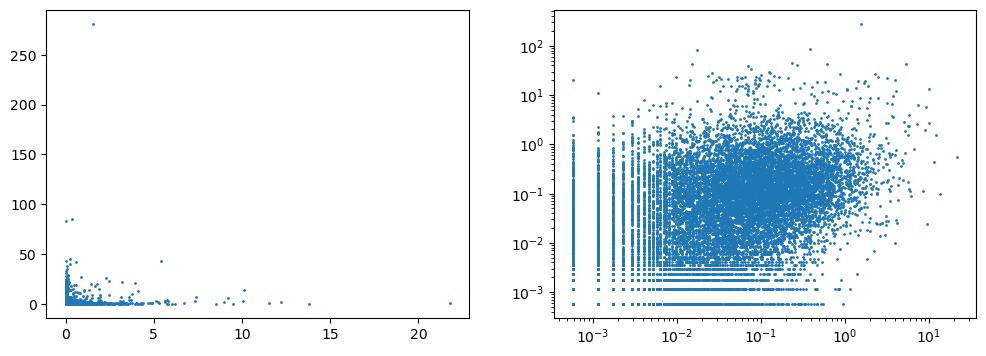

In [239]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [240]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.2118266912384782
s estimated by normalized covariance of total S counts = 0.20732547082006278
s estimated by normalized covariance of total counts = 0.20558493064695366
s estimated by total counts = 0.1051200890678582


s estimated by normalized covariance of Poission genes = 0.17318785776918857


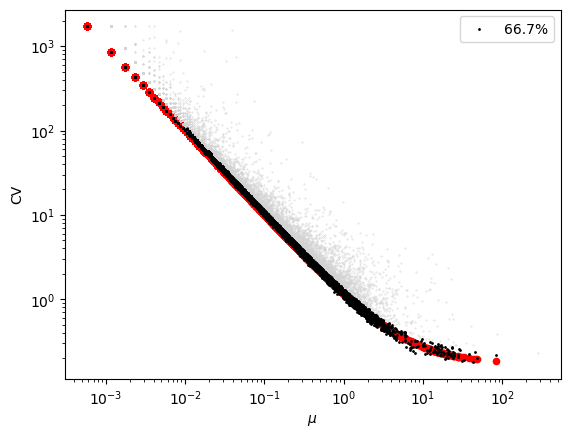

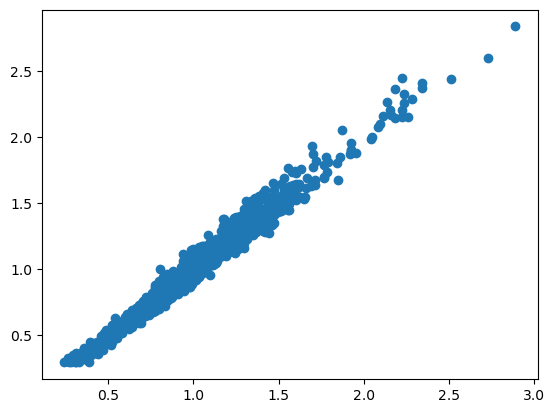

In [241]:
a=1
s=s1

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)

Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
P_cov = np.cov(P,rowvar=False)
P_mean = np.mean(P,axis=0)
P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,adata.X.toarray().mean(1)/adata.X.toarray().mean())

s estimated by normalized covariance of Poission genes = 0.17591638925757366


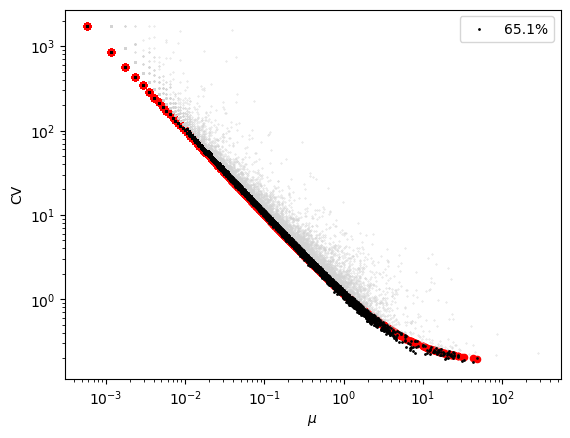

In [242]:
Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
P_cov = np.cov(P,rowvar=False)
P_mean = np.mean(P,axis=0)
P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

In [243]:
var_threshold = 1.5
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.1) & (S_mean > 0.1) \
    & (np.abs(np.log(S_mean/U_mean)) < 4) \
    & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold)
fitted_genes=adata.var_names[fitted_idx]

/tmp/ipykernel_2960309/2405989258.py:7: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4) \
/tmp/ipykernel_2960309/2405989258.py:7: RuntimeWarning: invalid value encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4) \
/tmp/ipykernel_2960309/2405989258.py:7: RuntimeWarning: divide by zero encountered in log
  & (np.abs(np.log(S_mean/U_mean)) < 4) \
/tmp/ipykernel_2960309/2405989258.py:8: RuntimeWarning: invalid value encountered in divide
  & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
/tmp/ipykernel_2960309/2405989258.py:9: RuntimeWarning: invalid value encountered in divide
  & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold)


In [244]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
fitted_genes = fitted_genes[~fitted_genes.isin(cell_cycle_genes)]
len(fitted_genes)

118

112


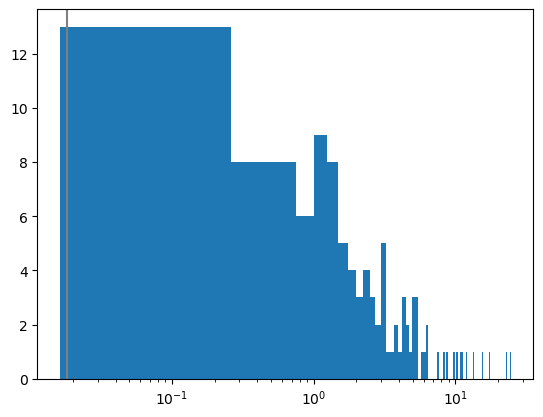

In [245]:
gene_length_file = np.loadtxt("data/gg_200525_genome_polyA_cum_3.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0] for gene in gene_length_file])

fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)
print(len(fitted_genes))

Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ])
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

/tmp/ipykernel_2960309/2755882506.py:2: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
/tmp/ipykernel_2960309/2755882506.py:3: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
/tmp/ipykernel_2960309/2755882506.py:7: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
/tmp/ipykernel_2960309/2755882506.py:8: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)


(1720, 112, 2)

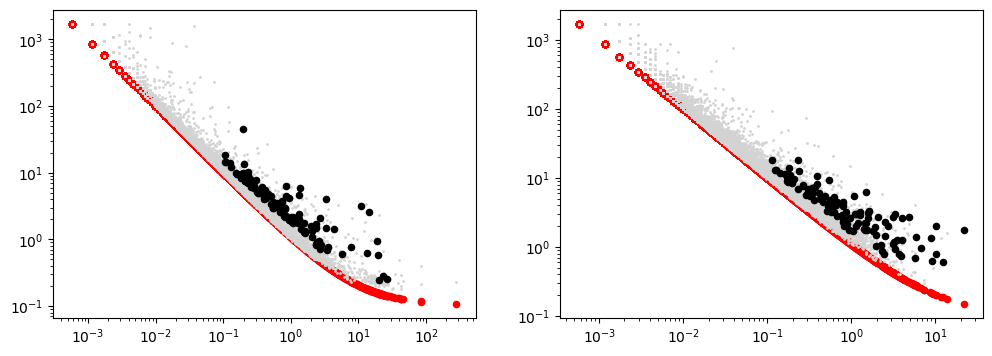

In [246]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

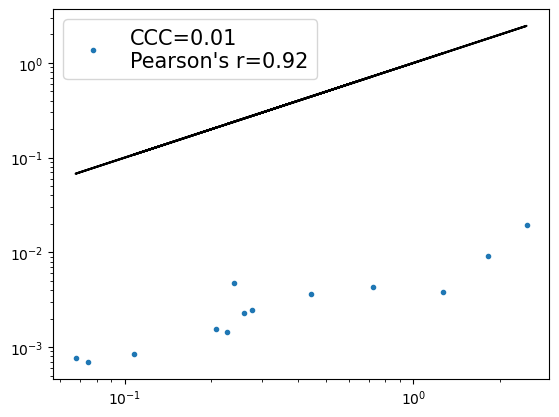

In [229]:
A = Schofield_gamma[fitted_idx]
B = Dyrec_gamma[fitted_idx]
plot_cor(A,B)

In [230]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
if plot_idx.sum() == 0:
    plot_idx = np.arange(10)
else:
    print(fitted_genes[plot_idx])

Index(['FBXO32', 'RBFOX1', 'STMN2'], dtype='object', name='Gene')


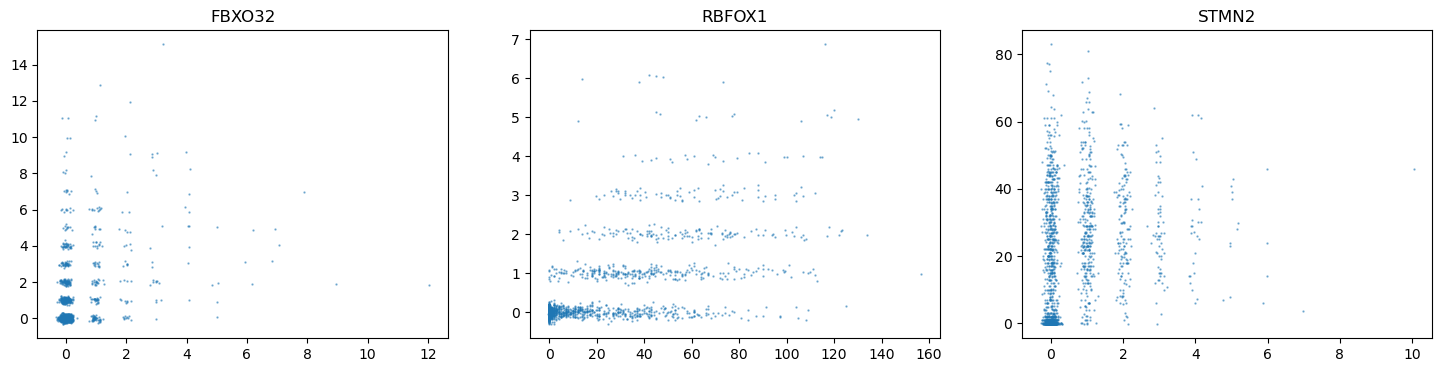

In [231]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

# Mixtures fitting

In [185]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

1 -1162.5507759851644 -1163.0531015665597 -1164.421958760837
2 -1003.0760470690278 -1004.0812796271673 -1006.8205783411781
3 -963.3904946235926 -964.8986341584764 -969.0083743922207
4 -949.4854198669343 -951.4964663785622 -956.9766481320402
5 -942.5013008082559 -945.015254296628 -951.8658775698395
6 -932.4184267787821 -935.4352872438983 -943.6563520368435


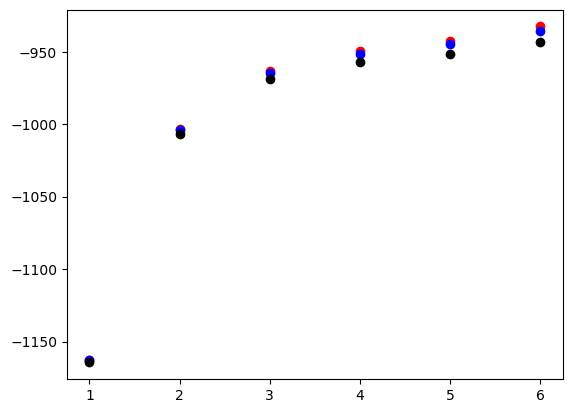

In [186]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixture(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    plt.scatter(nc,elbo,color='r')
    plt.scatter(nc,PM.compute_AIC(X_mix),color='b')
    plt.scatter(nc,PM.compute_BIC(X_mix),color='k')
    print(nc,PM.compute_lower_bound(X_mix),PM.compute_AIC(X_mix),PM.compute_BIC(X_mix))

In [187]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
PM.weights

array([0.24089153, 0.35232194, 0.40678653])

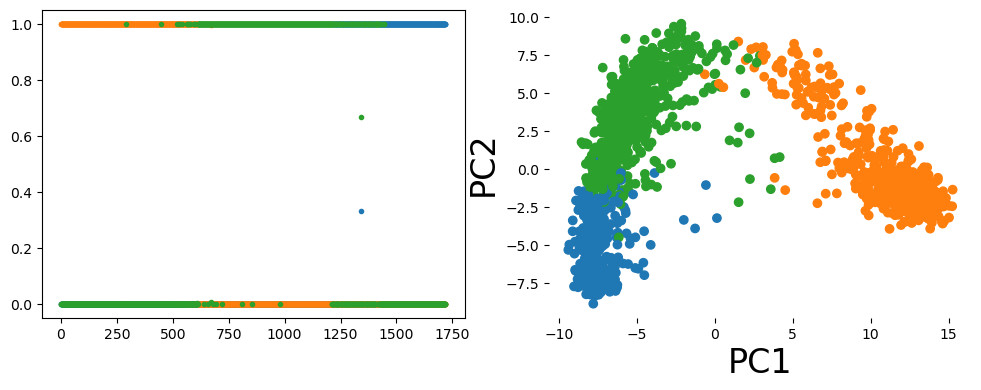

In [188]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=1)]);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

/tmp/ipykernel_2960309/2956382906.py:1: RuntimeWarning: divide by zero encountered in divide
  gbr = PM.theta[:,:,0]/PM.theta[:,:,1]


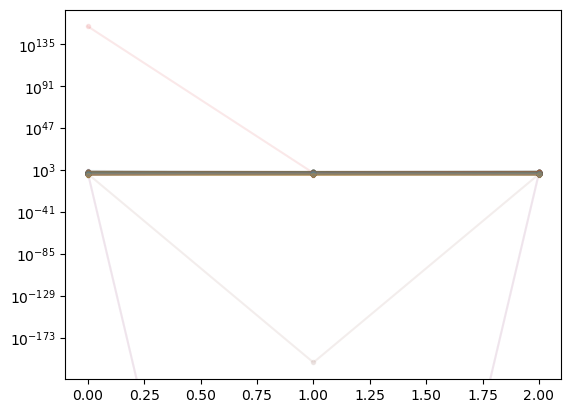

In [189]:
gbr = PM.theta[:,:,0]/PM.theta[:,:,1]

plt.plot(gbr,'.-',alpha=0.1);
plt.yscale('log')

In [190]:
weird_idx = np.where((gbr.max(0)/gbr.min(0))>100)[0]
fitted_genes[weird_idx]

/tmp/ipykernel_2960309/2897743958.py:1: RuntimeWarning: divide by zero encountered in divide
  weird_idx = np.where((gbr.max(0)/gbr.min(0))>100)[0]


Index(['GRIK3', 'ANGPTL1', 'PRDM16', 'PDGFD', 'SLC17A7', 'PRDM8', 'NRN1',
       'RGS20', 'SLC24A2'],
      dtype='object', name='Gene')

In [191]:
constant_idx = np.where(gbr.max(0)/gbr.min(0)<100)[0]

fitted_genes = fitted_genes[constant_idx]
fitted_idx = adata.var_names.isin(fitted_genes)

X = X[:,constant_idx]
Ub = Ub[constant_idx]
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])
X.shape

Index(['FBXO32', 'UNC5D', 'SEZ6', 'RBFOX1', 'DCX', 'GRIA3', 'STMN2', 'ELAVL4',
       'RNASEH2B'],
      dtype='object', name='Gene')


/tmp/ipykernel_2960309/151523103.py:1: RuntimeWarning: divide by zero encountered in divide
  constant_idx = np.where(gbr.max(0)/gbr.min(0)<100)[0]


(1720, 423, 2)

-953.257003690366


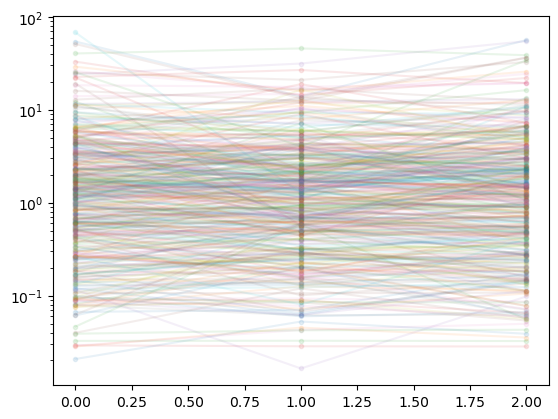

In [192]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
print(elbo)

gbr = PM.theta[:,:,0]/PM.theta[:,:,1]

plt.plot(gbr,'.-',alpha=0.1);
plt.yscale('log')

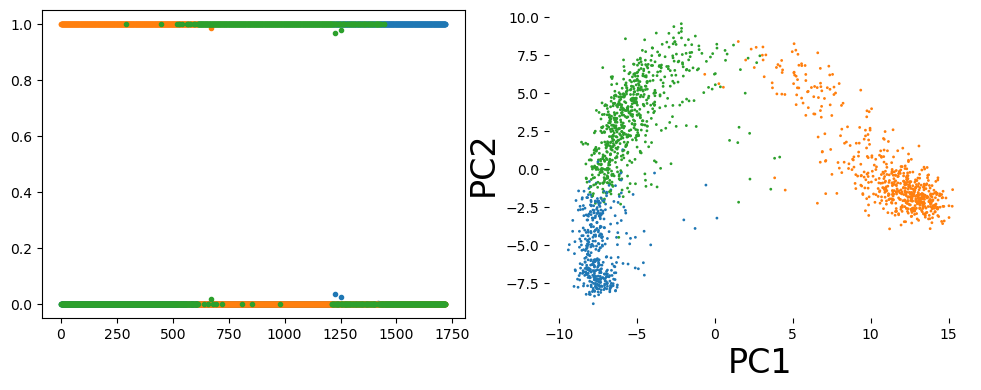

In [193]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=-1)],s=1);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

# Trajectory fitting

In [194]:
elbos = {}
traj_params_Ub={'r':rd,"Ub":Ub,"lambda_tau":0,"lambda_a":0}
traj_params={'r':rd,"lambda_tau":0,"lambda_a":0}

## Fine cluster

In [195]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

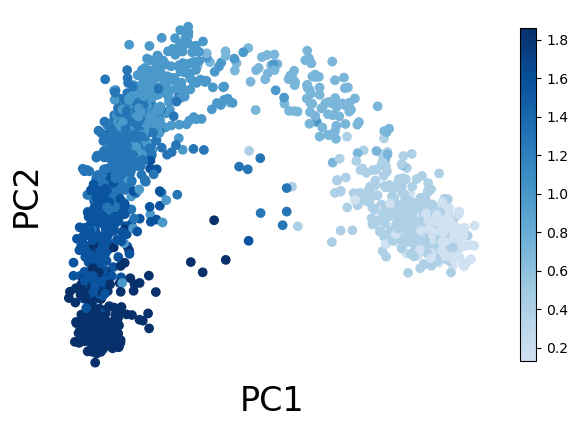

In [196]:
t_hat = Q0.sum(1)@np.linspace(0,2,m)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [197]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
traj_2 = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj_2 = traj_2.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=4,epoch=100)
print(traj_2.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [05:23<00:00,  3.23s/it]

-945.538954018192


In [70]:
topo = np.array([[0,1,2]])
tau = (0,1,2) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params_Ub,Q=Q0,parallel=True,n_threads=4,epoch=100)
print(traj.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]

-296.1893360846991


In [71]:
traj_r = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj_r = traj_r.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=np.flip(Q0,axis=-1),parallel=True,n_threads=4,epoch=100)
print(traj_r.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [03:32<00:00,  2.12s/it]

-292.9155881590016


In [80]:
topo = np.array([[0,1,2,3]])
tau = (0,1,2,3)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=4,epoch=100)
print(traj.elbos[-1])
traj_3 = copy.deepcopy(traj)

fitting with warm start


100%|██████████| 100/100 [09:37<00:00,  5.77s/it]

-289.42778373678084


In [113]:
topo = np.array([[0,1,2,3]])
tau = (0,1,2,3)
traj_r = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj_r = traj_r.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=np.flip(Q0,axis=-1),parallel=True,n_threads=4,epoch=100)
print(traj_r.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [04:59<00:00,  3.00s/it]

-294.9132730055295


In [232]:
traj = traj_3

[0.         1.14365687 2.37928964 3.        ]


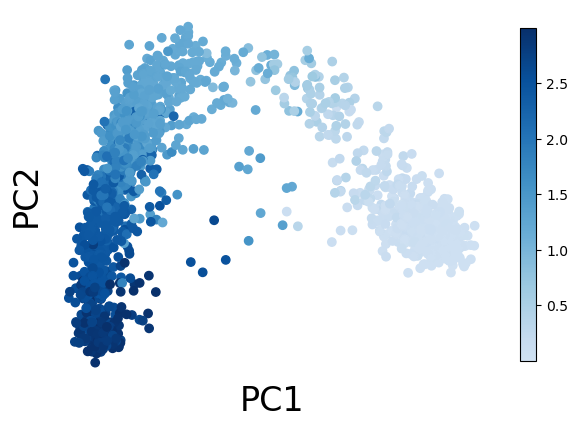

In [233]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

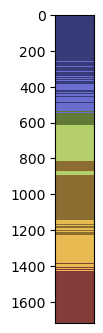

In [234]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

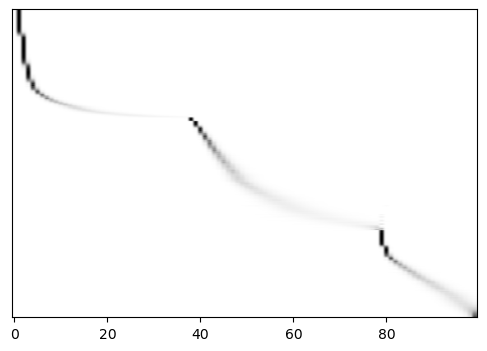

In [235]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

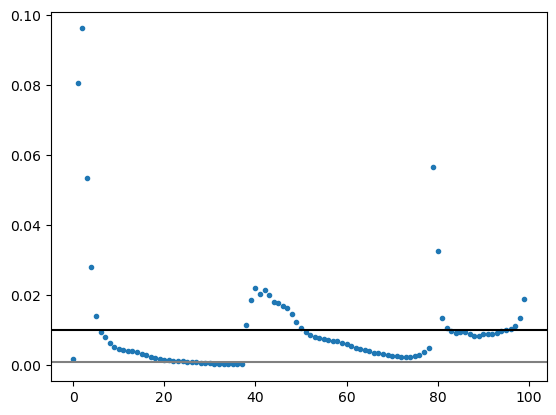

In [236]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

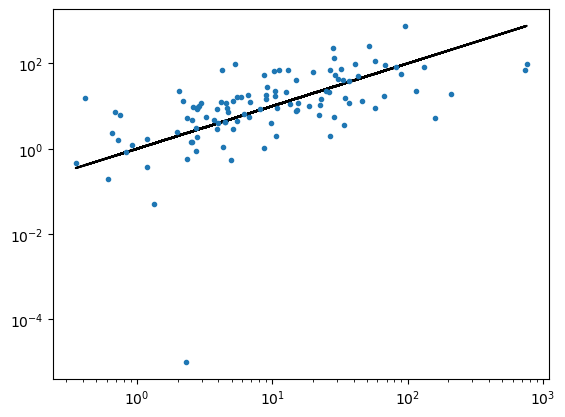

In [237]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-2],'k');
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.');

In [238]:
A = traj.theta[:,-1]
B = Schofield_gamma[fitted_idx]
plot_cor(A,B)

ValueError: operands could not be broadcast together with shapes (110,) (112,) 

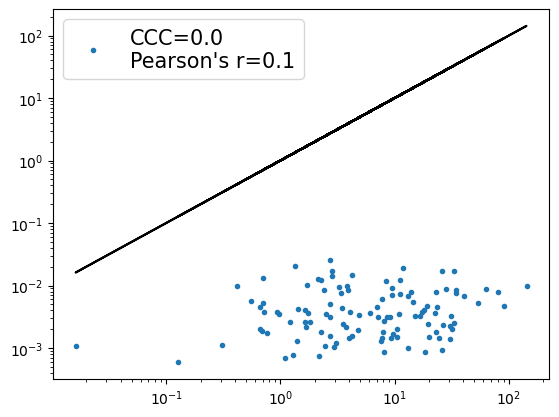

In [208]:
A = traj.theta[:,-1]
B = Dyrec_gamma[fitted_idx]
plot_cor(A,B)

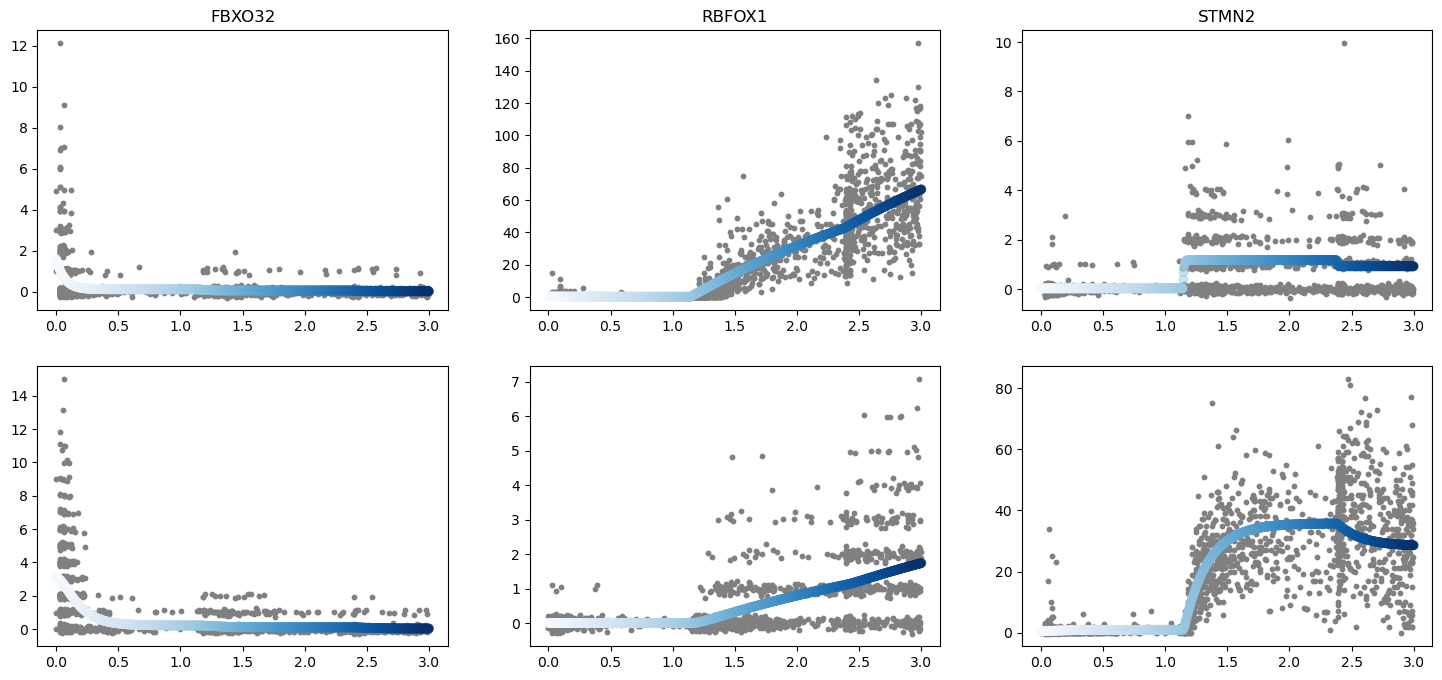

In [123]:
plot_y(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

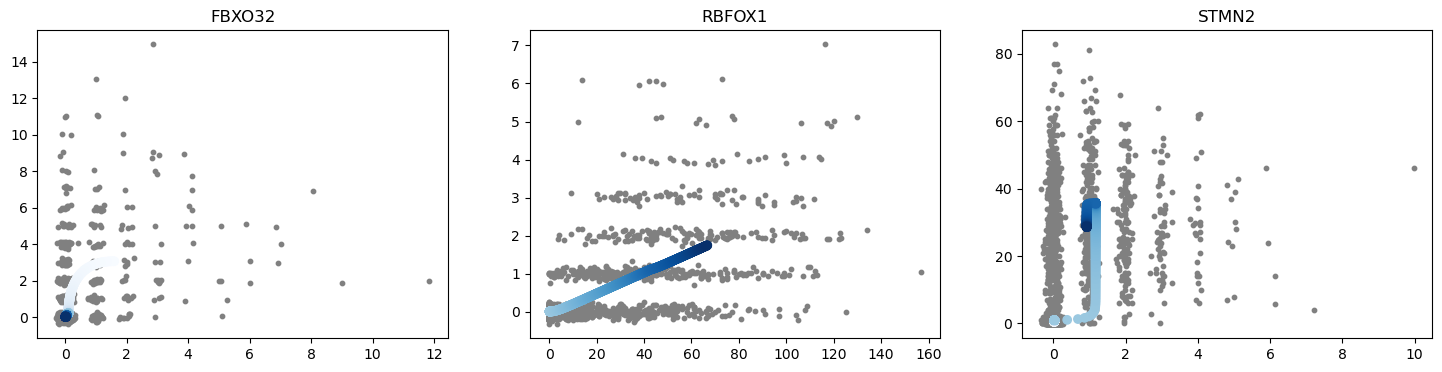

In [124]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

5


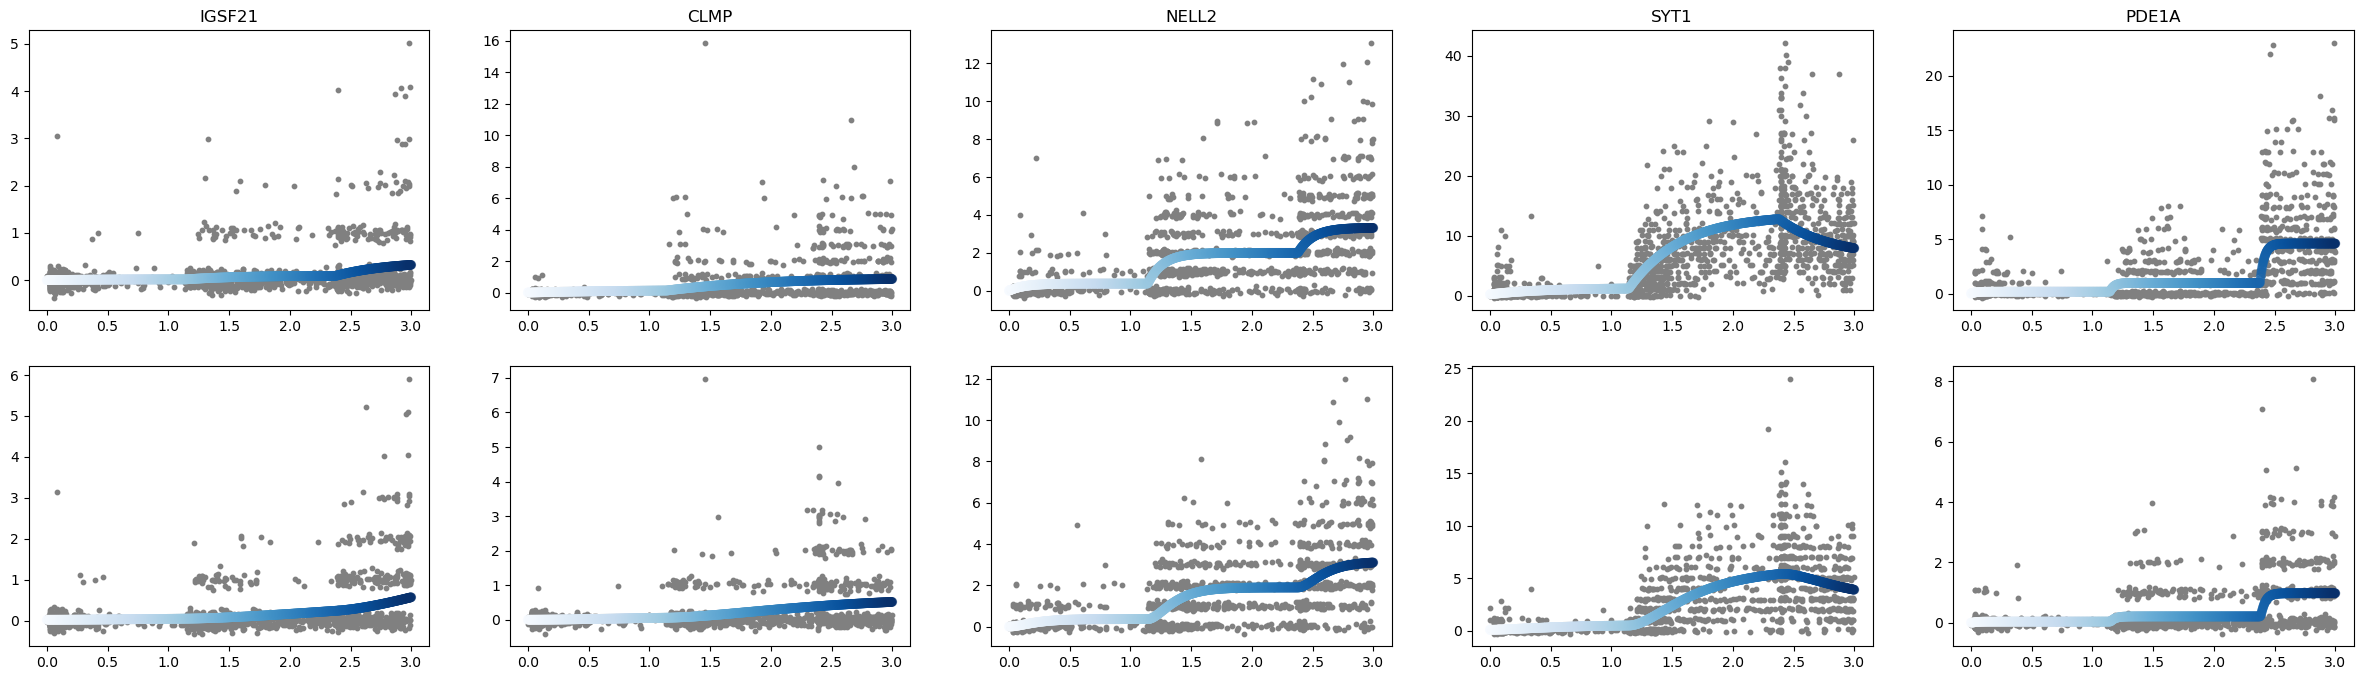

In [128]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 5*traj.theta[:,1]) & (traj.theta[:,1] > 5*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

In [93]:
plot_marker_genes = known_marker_genes

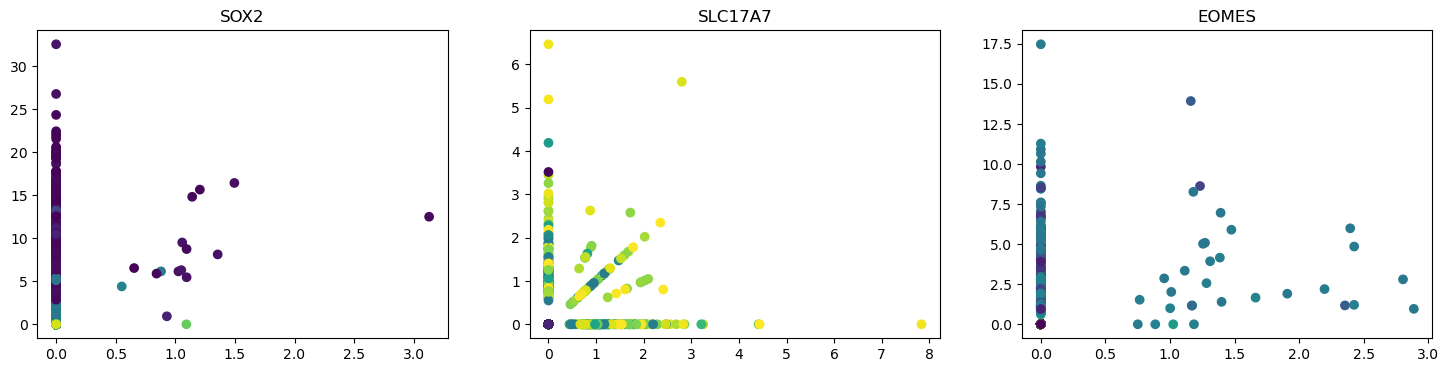

In [94]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

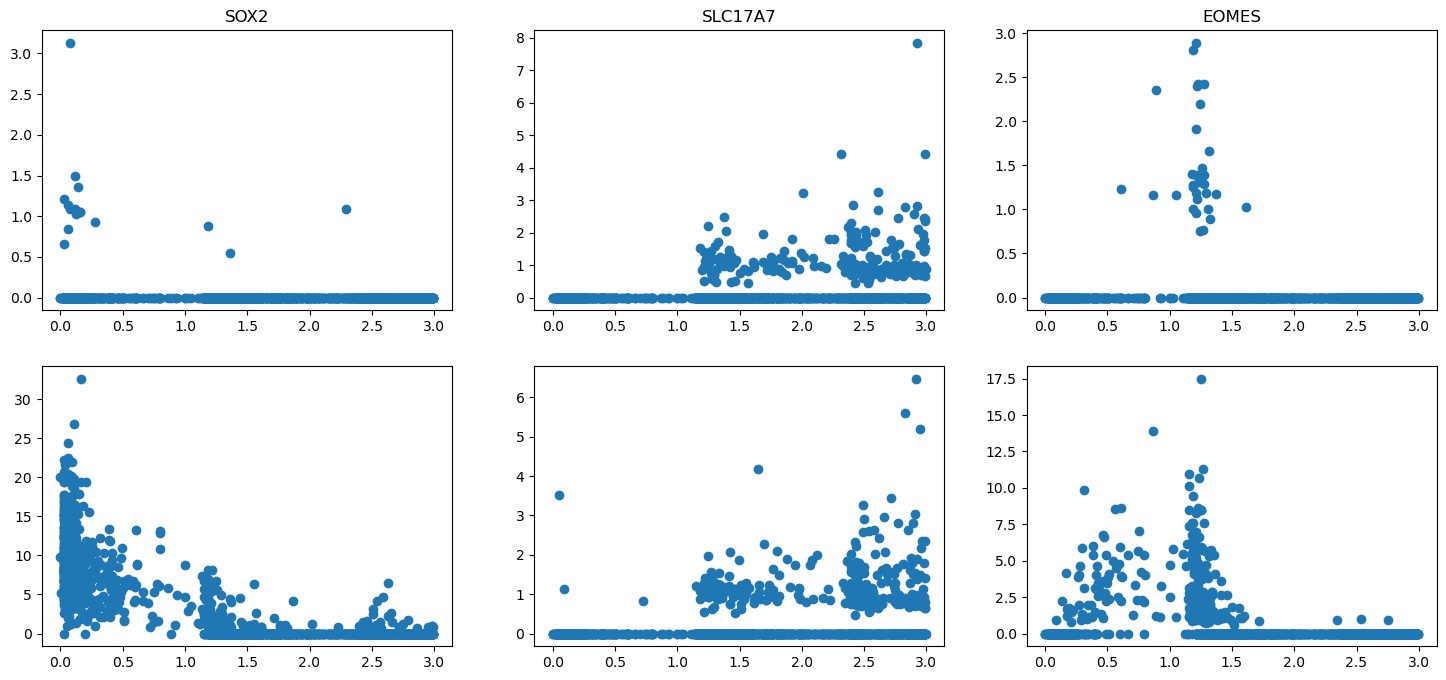

In [95]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2'), Text(3, 0, 'α3')]

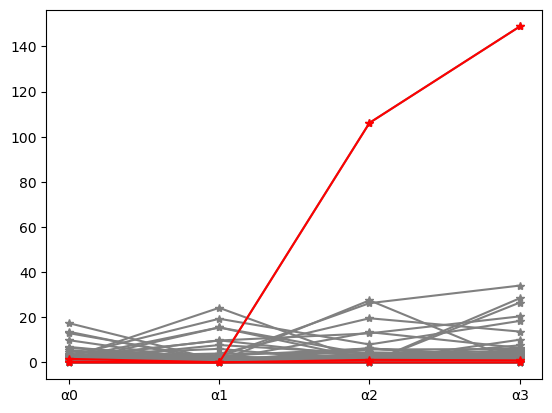

In [127]:
p=traj.theta.shape[0]
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2,3]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2,3]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2', 'α3']
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

1


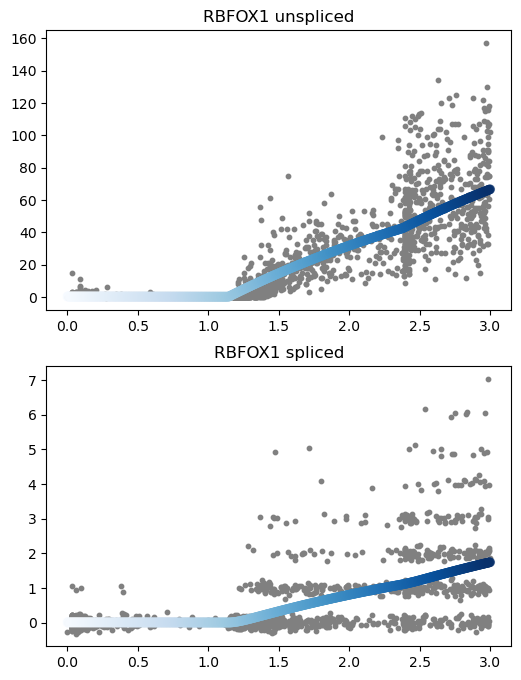

In [129]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 100)
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

In [47]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

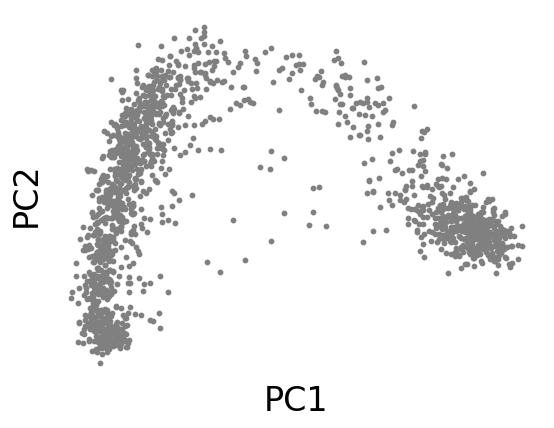

In [130]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [131]:
from multiprocessing import Pool

tau = (0,1,2,3)
topo = np.array([[0,1,2,3]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [169]:
import pickle 

with open('results/Forebrain.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

In [247]:
with open('results/Forebrain.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    trajs = pickle.load(f)

/tmp/ipykernel_2960309/3120039309.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')


Text(0.5, 1.0, 'Random initialiazation')

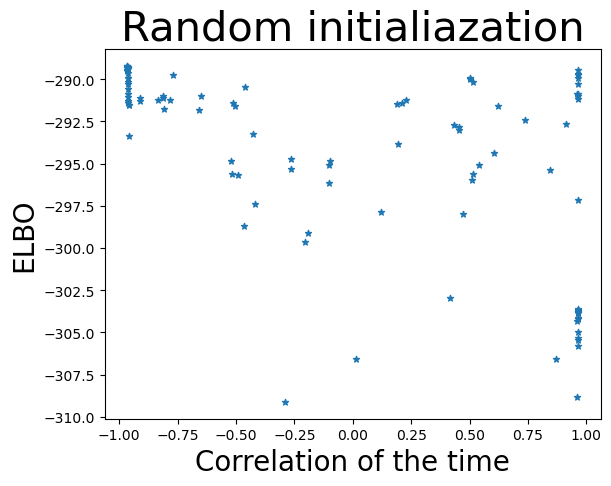

In [249]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [250]:
idx = np.array(np.where(np.array(corrs)>0.8)[0],dtype=int)
iii = np.argmax(np.array(elbos)[idx])
traj = trajs[idx[iii]]
elbos[idx[iii]]

-289.45182982383733

In [170]:
traj = trajs[np.argmax(elbos)]
np.max(elbos)

-289.2088537972644

In [154]:
traj_tau = Trajectory(traj.topo, traj.tau, model="two_species_ss_tau",verbose=1)
traj_tau = traj_tau.fit(X,warm_start=True,params=traj.params,Q=traj.Q.copy(),parallel=True,n_threads=4,epoch=10)
print(traj_tau.compute_AIC(X,standard=False))

fitting with warm start


100%|██████████| 10/10 [01:12<00:00,  7.23s/it]

-318.202449724539


In [156]:
traj = traj_tau

0.09974343937948214


ValueError: operands could not be broadcast together with shapes (112,) (110,) 

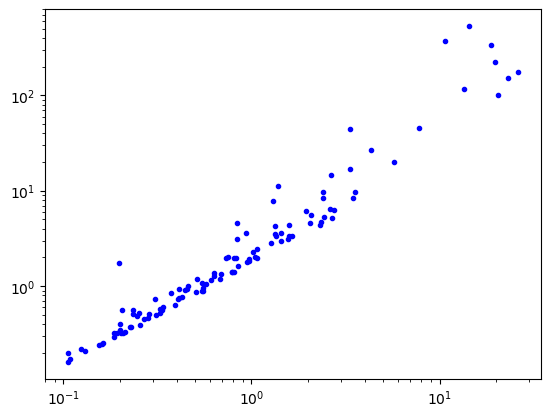

In [251]:
Y = traj.get_Y_hat(traj.theta, t_hat, traj.tau, traj.topo, traj.params)[0]
rd_s = traj.params['r'].var()/traj.params['r'].mean()**2
print(rd_s)
mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)
plt.loglog(mean,var,'b.')
plt.loglog(mean,rd_s*mean**2+mean+(1+rd_s)*Y_var,'r.')
signal = Y_var
noise = var-rd_s*mean**2-(1+rd_s)*Y_var
unexplained = noise - mean
print((signal/mean).mean(),(noise/mean).mean())

[0.         1.0176491  2.31966103 3.        ]


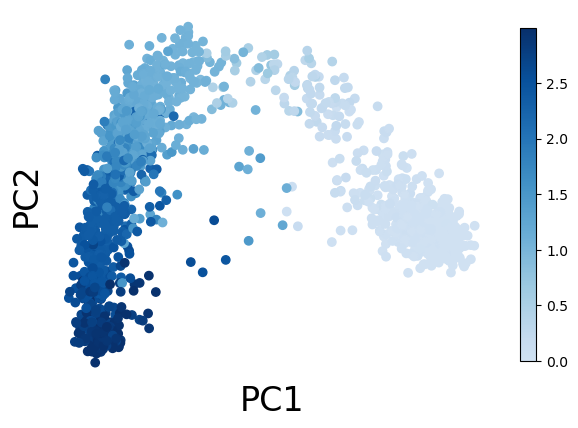

In [252]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

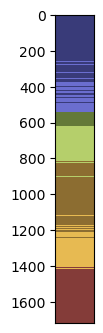

In [253]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

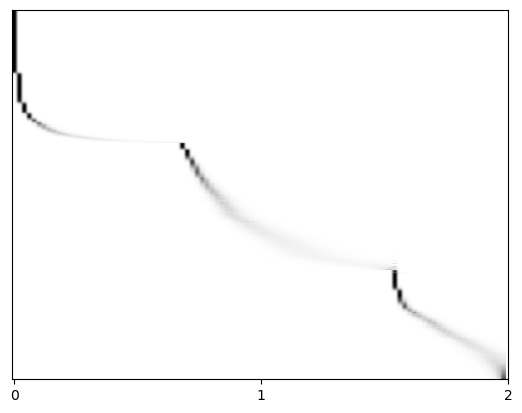

In [254]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

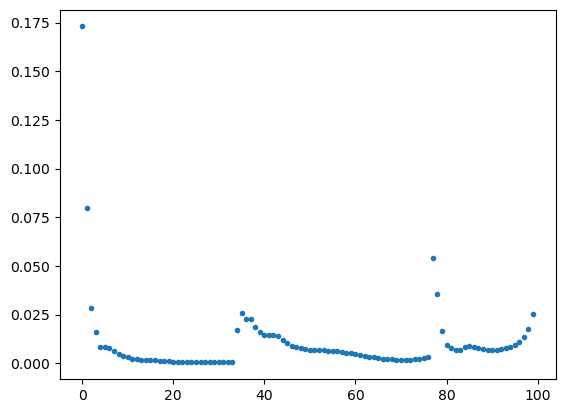

In [255]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')

In [256]:
A = traj.theta[:,-1]
B = Dyrec_gamma[fitted_idx]
plot_cor(A,B)

ValueError: operands could not be broadcast together with shapes (110,) (112,) 

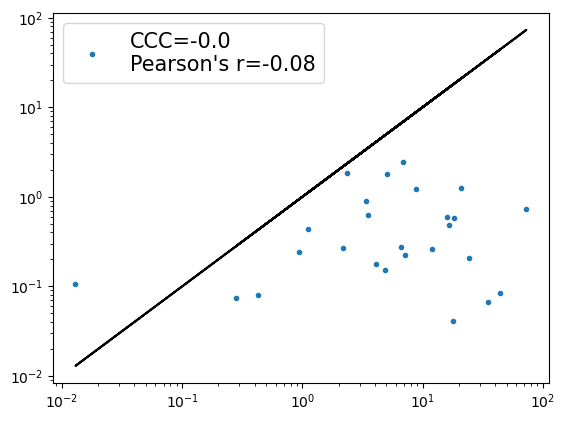

In [177]:
A = traj.theta[:,-1]
B = Schofield_gamma[fitted_idx]
plot_cor(A,B)

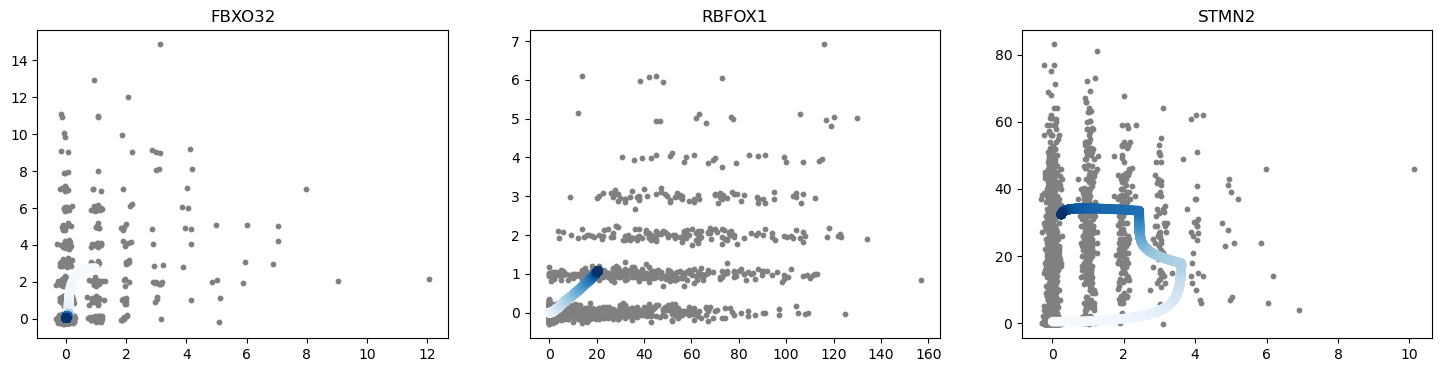

In [163]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

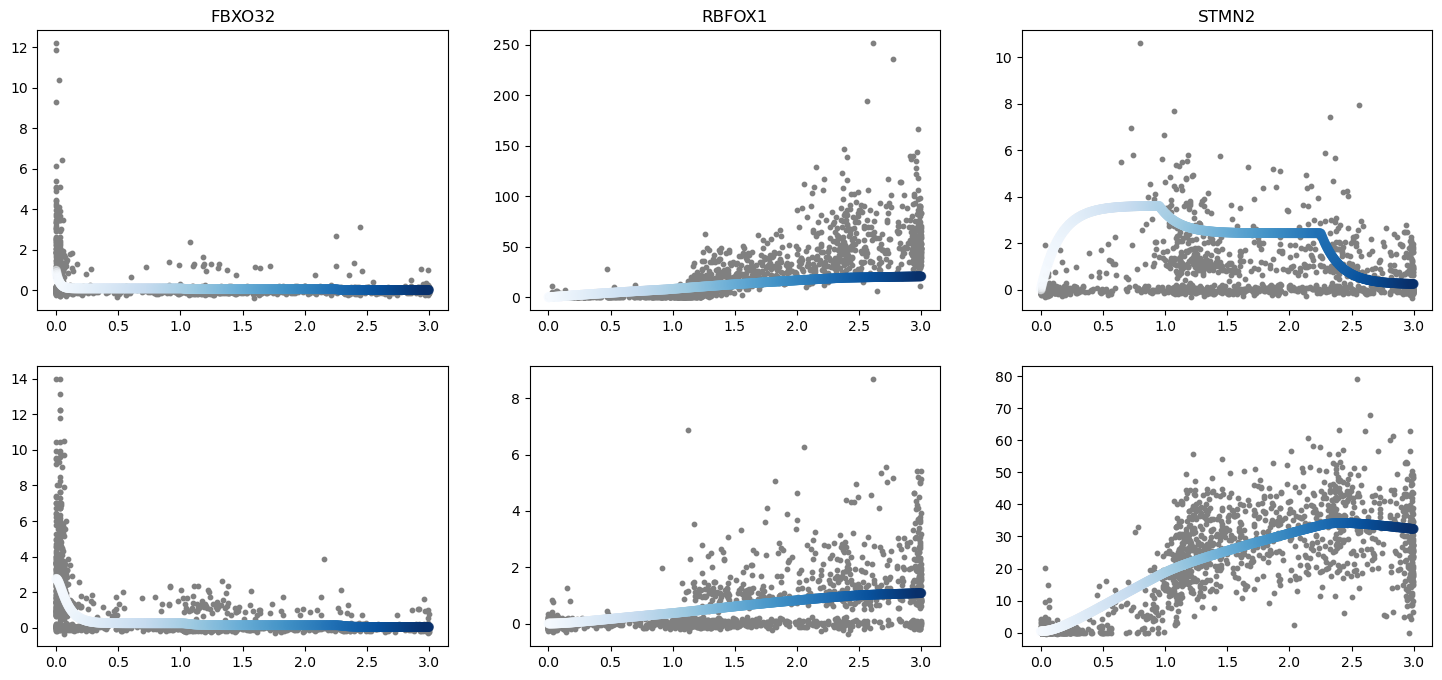

In [165]:
plot_y(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

11


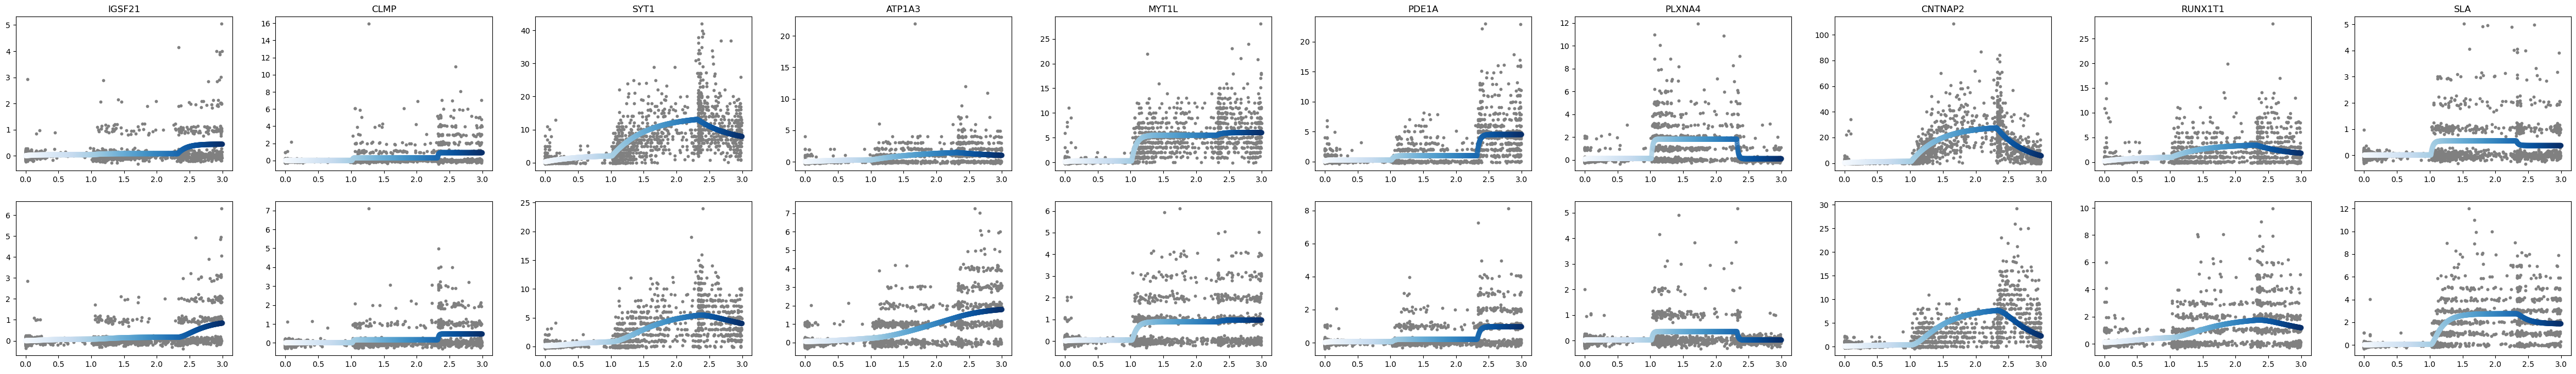

In [150]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

### two_species_ss_tau

In [ ]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
Input_args = []

def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss_tau", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [ ]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]

In [ ]:
plt.hist(traj.theta[:,-3])

In [ ]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

### two_species

In [ ]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [ ]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]
traj.elbos[0][-1]

In [ ]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

In [ ]:
traj = trajs[np.argmax(corrs)]
traj.elbos[0][-1]

In [ ]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

# Synthetic data

In [ ]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=4,epoch=100)

In [ ]:
print(traj.elbos[-1])

In [ ]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
plot_t(traj,order_cells=True)

In [ ]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

In [ ]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

In [ ]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [ ]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()

Input_args = []
def fit_wrapper(seed):
    syn_traj = Trajectory(syn_topo, syn_tau, model="two_species_ss", verbose=0)
    syn_traj = syn_traj.fit(syn_X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return syn_traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    syn_trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [ ]:
corrs = []
elbos = []
for syn_traj in syn_trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)